In [1]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.9 MB/s 


In [2]:
from skimage.io import imread, imshow
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
import numpy as np
import lpips
import torch
import math
import os
import time

In [3]:
start_time = time.time()

In [4]:
# MAE
# PSNR
# SSIM
# LPIPS

In [5]:
# https://github.com/richzhang/PerceptualSimilarity

In [6]:
def mean_squared_error(a, b):
  t = 0
  n = 0
  
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      for k in range(a.shape[2]):
        t += (a[i][j][k] - b[i][j][k])**2
        n += 1
  
  t /= n

  return t

In [7]:
def peak_signal_to_noise_ratio(mse):
  return 10 * math.log10((255**2)/(mse))

In [8]:
def carrega_dataset(directory):
  arr = []

  for file in os.listdir(directory):
    f = imread(directory + '/' + file)
    arr.append(f)
  
  arr = np.array(arr).astype('int64')

  return arr

In [9]:
dataset_original = carrega_dataset('dataset_original')
dataset_encoder = carrega_dataset('dataset_encoder')

In [10]:
dataset_original.shape

(1000, 64, 64, 3)

In [11]:
dataset_encoder.shape

(1000, 64, 64, 3)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


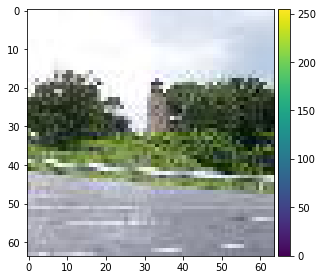

In [12]:
imshow(dataset_original[0])

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


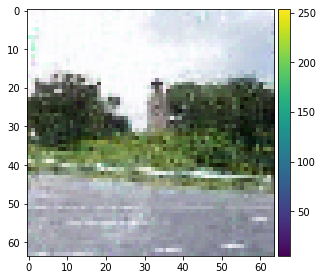

In [13]:
imshow(dataset_encoder[0])

In [14]:
diff = np.abs(dataset_original - dataset_encoder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


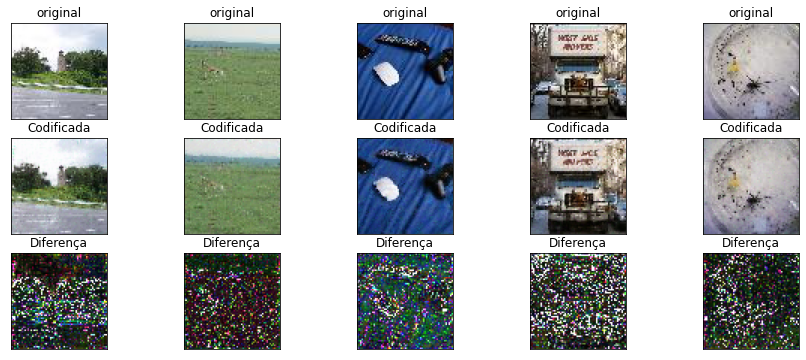

In [15]:
n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(dataset_original[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(dataset_encoder[i])
  plt.title("Codificada")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
    
  ax = plt.subplot(3, n, i + 1 + n + n)
  plt.imshow(diff[i] * 10)
  plt.title("Diferença")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('dieferença_imagens.png')
plt.show()

In [16]:
mseMedio = 0
psnrMedio = 0
ssimMedio = 0

mseVet = []
psnrVet = []
ssimVet = []

for i in range(dataset_original.shape[0]):
  mse = mean_squared_error(dataset_original[i], dataset_encoder[i])
  mseMedio += mse
  mseVet.append(mse)

  psnr = peak_signal_to_noise_ratio(mse)
  psnrMedio += psnr
  psnrVet.append(psnr)

  ssim = structural_similarity(dataset_original[i], dataset_encoder[i], multichannel=True)
  ssimMedio += ssim
  ssimVet.append(ssim)

mseMedio /= dataset_original.shape[0]
psnrMedio /= dataset_original.shape[0]
ssimMedio /= dataset_original.shape[0]

print('MSE Médio:', mseMedio)
print('PSNR Médio:', psnrMedio)
print('SSIM Médio:', ssimMedio)

MSE Médio: 271.2275071614582
PSNR Médio: 24.571331659658572
SSIM Médio: 1.0


In [17]:
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [18]:
dataset_original = (dataset_original - 127.5) / 127.5
dataset_encoder = (dataset_encoder - 127.5) / 127.5

In [19]:
dataset_original_t = []
dataset_encoder_t = []

for i in dataset_original:
  dataset_original_t.append(i.T)

for i in dataset_encoder:
  dataset_encoder_t.append(i.T)

dataset_original_t = np.array(dataset_original_t)
dataset_encoder_t = np.array(dataset_encoder_t)

In [20]:
loss_fn_alex(torch.from_numpy(np.array([dataset_original[0].T])).float(), torch.from_numpy(np.array([dataset_original[0].T])).float())

tensor([[[[0.]]]], grad_fn=<AddBackward0>)

In [21]:
loss_fn_alex(torch.from_numpy(np.array([dataset_original[1].T])).float(), torch.from_numpy(np.array([dataset_encoder[1].T])).float())

tensor([[[[0.0317]]]], grad_fn=<AddBackward0>)

In [22]:
alex = loss_fn_alex(torch.from_numpy(dataset_original_t).float(), torch.from_numpy(dataset_encoder_t).float())

In [23]:
loss_fn_vgg(torch.from_numpy(np.array([dataset_original[0].T])).float(), torch.from_numpy(np.array([dataset_original[0].T])).float())

tensor([[[[0.]]]], grad_fn=<AddBackward0>)

In [24]:
loss_fn_vgg(torch.from_numpy(np.array([dataset_original[1].T])).float(), torch.from_numpy(np.array([dataset_encoder[1].T])).float())

tensor([[[[0.1590]]]], grad_fn=<AddBackward0>)

In [25]:
vgg = loss_fn_vgg(torch.from_numpy(dataset_original_t).float(), torch.from_numpy(dataset_encoder_t).float())

In [26]:
alexNp = alex.cpu().detach().numpy()
vggNp = vgg.cpu().detach().numpy()

In [27]:
alexVet = []
vggVet = []

for i in range(alexNp.shape[0]):
  alexVet.append(alexNp[i][0][0][0])
  vggVet.append(vggNp[i][0][0][0])

alexVet = np.array(alexVet)
vggVet = np.array(vggVet)

In [28]:
print('Alex Médio:', alexVet.mean())
print('VGG Médio:', vggVet.mean())

Alex Médio: 0.044299792
VGG Médio: 0.1356184


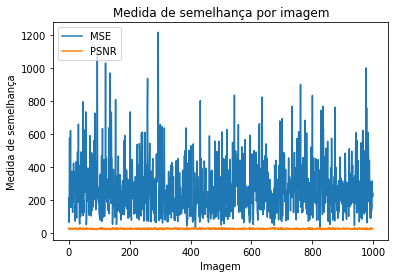

In [29]:
legend = []

plt.plot(mseVet)
legend.append('MSE')
plt.plot(psnrVet)
legend.append('PSNR')
plt.title('Medida de semelhança por imagem')
plt.ylabel('Medida de semelhança')
plt.xlabel('Imagem')
plt.legend(legend, loc='upper left')
plt.savefig('medida_de_semelhança_por_imagem_1.png')
plt.show()

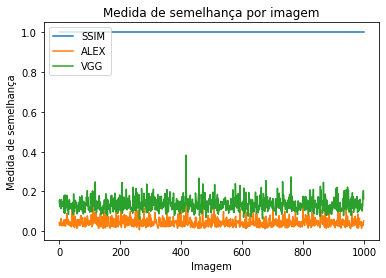

In [30]:
legend = []

plt.plot(ssimVet)
legend.append('SSIM')
plt.plot(alexVet)
legend.append('ALEX')
plt.plot(vggVet)
legend.append('VGG')
plt.title('Medida de semelhança por imagem')
plt.ylabel('Medida de semelhança')
plt.xlabel('Imagem')
plt.legend(legend, loc='upper left')
plt.savefig('medida_de_semelhança_por_imagem_2.png')
plt.show()

In [31]:
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 60.794743061065674 seconds ---
